# Machine Learning Project

#### 1. Predicting losses of financial institutions
#### 2. Model evaluation metric used is Mean Abosulte Percentage Error


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import MultiTaskLasso, OrthogonalMatchingPursuit, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, TheilSenRegressor, HuberRegressor, ARDRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 101)

## Data Cleaning, Wrangling & Visualization

In [3]:
# Import the test and train dataset and concatenate them for cleaning.
train_data = pd.read_csv("training_data.csv")
train_data["data_type"] = "train"
test_data = pd.read_csv("testing_data.csv")
test_data["data_type"] = "test"
data_df = pd.concat([train_data, test_data])

In [4]:
data_df.head()

,Unnamed: 0,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity,estimated_loss,data_type
0,1,1,AMERICAN DIVERSIFIED SAVINGS BANK,SAVINGS ASSOCIATION,FEDERAL/STATE,"COSTA MESA, CA",33.663339,-117.903317,2/14/1986,FSLIC,PAYOUT,958.953,978.635,0.979888,472.36480,train
1,2,2,COMMUNITYSOUTH BANK AND TRUST,COMMERCIAL BANK,STATE,"EASLEY, SC",34.826928,-82.581705,1/21/2011,DIF,ACQUISITION,314.250,340.986,0.921592,51.33000,train
2,3,3,WATSON STATE BANK,COMMERCIAL BANK,STATE,"WATSON, MN",45.009723,-95.801348,9/30/1988,FDIC,ACQUISITION,12.865,NaN,0.936931,5.10400,train
3,4,4,FIRST AMERICA FSB,SAVINGS BANK,STATE,"LONGMONT, CO",40.167212,-105.101929,3/16/1990,RTC,PAYOUT,146.818,187.366,0.783589,41.29300,train
4,5,5,BANK OF HUNTER,COMMERCIAL BANK,STATE,"HUNTER, OK",36.563643,-97.661163,4/4/1985,FDIC,ACQUISITION,3.109,3.001,1.035988,1.19114,train


In [5]:
# Description of our dataset
data = data_df
data.describe()

,Unnamed: 0,id,latitude,longitude,total_deposits,total_assets,liquidity,estimated_loss
count,2968.000000,2968.000000,2968.000000,2968.000000,2726.000000,2812.000000,2830.000000,2612.000000
mean,1171.200809,1171.200809,36.595602,-93.245752,220.667196,261.574969,0.946101,60.300897
std,797.585858,797.585858,6.281885,15.937895,841.740272,1146.036266,0.218581,314.047100
min,1.000000,1.000000,-34.000000,-157.855676,0.005000,0.014000,0.068777,0.001000
25%,386.750000,386.750000,32.470361,-98.476062,13.082250,13.398000,0.882006,2.380235
50%,1128.500000,1128.500000,36.049806,-94.824681,38.336500,39.035000,0.950272,8.862500
75%,1870.250000,1870.250000,40.853905,-85.140767,131.921750,139.089250,0.996469,35.115500
max,2612.000000,2612.000000,69.750000,147.164340,20072.099000,30698.512000,8.897978,12438.005000


In [6]:
# Converting "failure_date" column to datetime format
data_df['failure_date'] = pd.to_datetime(data_df['failure_date'])
# Extracting year and month from the above column and adding them as new columns
data_df['failure_year'] = data_df['failure_date'].dt.year
data_df['failure_month'] = data_df['failure_date'].dt.month

In [7]:
# Checking if columns have been added and datetime format has been corrected
data_df.head()

,Unnamed: 0,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity,estimated_loss,data_type,failure_year,failure_month
0,1,1,AMERICAN DIVERSIFIED SAVINGS BANK,SAVINGS ASSOCIATION,FEDERAL/STATE,"COSTA MESA, CA",33.663339,-117.903317,1986-02-14,FSLIC,PAYOUT,958.953,978.635,0.979888,472.36480,train,1986,2
1,2,2,COMMUNITYSOUTH BANK AND TRUST,COMMERCIAL BANK,STATE,"EASLEY, SC",34.826928,-82.581705,2011-01-21,DIF,ACQUISITION,314.250,340.986,0.921592,51.33000,train,2011,1
2,3,3,WATSON STATE BANK,COMMERCIAL BANK,STATE,"WATSON, MN",45.009723,-95.801348,1988-09-30,FDIC,ACQUISITION,12.865,NaN,0.936931,5.10400,train,1988,9
3,4,4,FIRST AMERICA FSB,SAVINGS BANK,STATE,"LONGMONT, CO",40.167212,-105.101929,1990-03-16,RTC,PAYOUT,146.818,187.366,0.783589,41.29300,train,1990,3
4,5,5,BANK OF HUNTER,COMMERCIAL BANK,STATE,"HUNTER, OK",36.563643,-97.661163,1985-04-04,FDIC,ACQUISITION,3.109,3.001,1.035988,1.19114,train,1985,4


In [8]:
# Splitting Headquarters data into City and State
data_df['headquarters'] = data_df['headquarters'].str.rstrip()
data_df['city'] = data_df['headquarters'].str.rsplit(',', 1).str[0].str.strip()
data_df['state'] = data_df['headquarters'].str.rsplit(',', 1).str[1].str.strip()

In [9]:
# Checking if City and State have been added
data_df.head()

,Unnamed: 0,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity,estimated_loss,data_type,failure_year,failure_month,city,state
0,1,1,AMERICAN DIVERSIFIED SAVINGS BANK,SAVINGS ASSOCIATION,FEDERAL/STATE,"COSTA MESA, CA",33.663339,-117.903317,1986-02-14,FSLIC,PAYOUT,958.953,978.635,0.979888,472.36480,train,1986,2,COSTA MESA,CA
1,2,2,COMMUNITYSOUTH BANK AND TRUST,COMMERCIAL BANK,STATE,"EASLEY, SC",34.826928,-82.581705,2011-01-21,DIF,ACQUISITION,314.250,340.986,0.921592,51.33000,train,2011,1,EASLEY,SC
2,3,3,WATSON STATE BANK,COMMERCIAL BANK,STATE,"WATSON, MN",45.009723,-95.801348,1988-09-30,FDIC,ACQUISITION,12.865,NaN,0.936931,5.10400,train,1988,9,WATSON,MN
3,4,4,FIRST AMERICA FSB,SAVINGS BANK,STATE,"LONGMONT, CO",40.167212,-105.101929,1990-03-16,RTC,PAYOUT,146.818,187.366,0.783589,41.29300,train,1990,3,LONGMONT,CO
4,5,5,BANK OF HUNTER,COMMERCIAL BANK,STATE,"HUNTER, OK",36.563643,-97.661163,1985-04-04,FDIC,ACQUISITION,3.109,3.001,1.035988,1.19114,train,1985,4,HUNTER,OK


In [10]:
# Assigning data_df to another variable as this would be used in visualization to avoid manipulation of original data
plot_df2 = data_df

$$ \text{Liquidity} = \frac{\text{total_deposits}}{\text{total_assets}} $$

In [11]:
# From above formula, filling missing cells
# Therefore filling missing values in total_deposits using above formula
data_df['total_deposits'] = np.where((data_df['total_deposits'].isnull()) & (~data_df['total_assets'].isnull()) & 
                                     (~data_df['liquidity'].isnull()),
                                     data_df['total_assets'] * data_df['liquidity'], data_df['total_deposits'])
# Similarly filling missing values in total_assets using above formula 
data_df['total_assets'] = np.where((data_df['total_assets'].isnull()) & (~data_df['total_deposits'].isnull()) & 
                                     (~data_df['liquidity'].isnull()),data_df['total_deposits']/ 
                                     data_df['liquidity'], data_df['total_assets'])
# Similarly filling missing values in liquidity using above formula
data_df['liquidity'] = np.where((data_df['liquidity'].isnull()) & (~data_df['total_deposits'].isnull()) & 
                                     (~data_df['total_assets'].isnull()),data_df['total_deposits'] / 
                                     data_df['total_assets'], data_df['liquidity'])
# Dropping the remaining null values where 2 out of 3 variables are missing
data_df = data_df[~((data_df['data_type'] == 'train') & (data_df[['total_deposits', 'total_assets', 'liquidity']].isnull().any(axis=1)))]
# We have dropped 39 values as they are very small compared to our datasize (1.5%). So they shouldn't impact our model!

In [12]:
# Checking if null values have been dropped from train set and not test set
data_df.isnull().sum()

Unnamed: 0              0
id                      0
institution_name        0
institution_type        0
charter_type            0
headquarters            0
latitude                0
longitude               0
failure_date            0
insurance_provider      0
failure_outcome         0
total_deposits          0
total_assets            0
liquidity               0
estimated_loss        356
data_type               0
failure_year            0
failure_month           0
city                    0
state                   0
dtype: int64

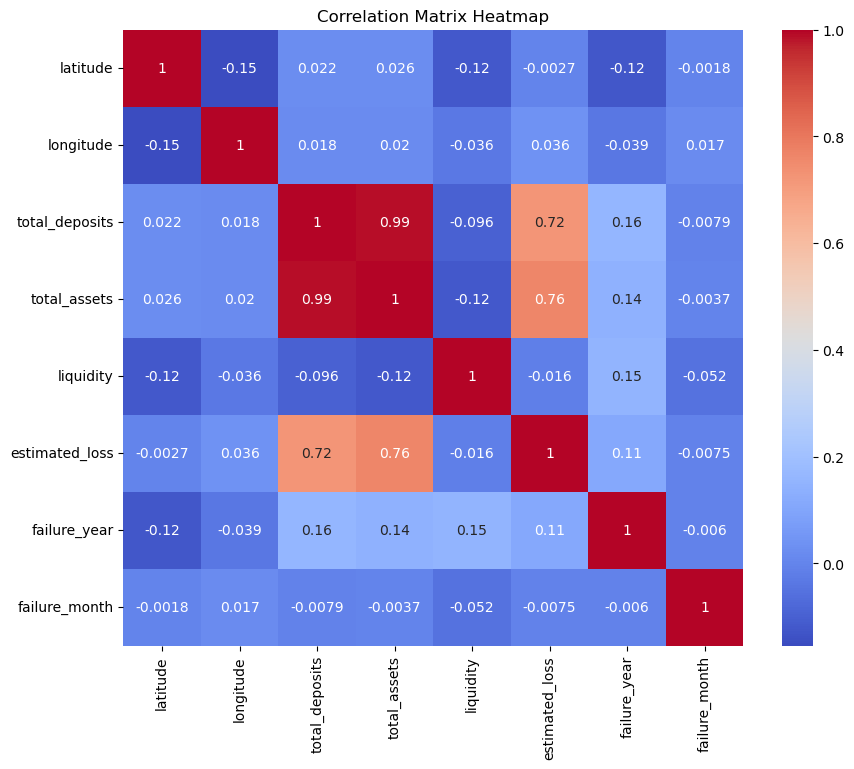

In [13]:
# Plotting heat map to see correlation of variables across and to see correlation of estimated losses with other variables
ax = plt.subplots(figsize=(10,8))
a_cols = ['institution_name', 'institution_type', 'charter_type', 'headquarters', 'latitude', 'longitude', 'failure_date', 'insurance_provider', 'failure_outcome', 'total_deposits', 'total_assets', 'liquidity', 'estimated_loss', 'data_type', 'failure_year', 'failure_month', 'city', 'state']
sns.heatmap(data_df[a_cols].corr(), cmap='coolwarm', annot=True)

# Adding labels and showing plot
plt.title("Correlation Matrix Heatmap")
plt.show()

In [14]:
# Creating groups for longitude and latitude data
grouping = np.linspace(min(data_df['latitude']), max(data_df['latitude']), num=10) # created 10 groups ranging from 69.5 to -34
data_df['latitude_bins'] = pd.cut(data_df['latitude'], grouping, labels=False,include_lowest=True)
grouping = np.linspace(min(data_df['longitude']),max(data_df['longitude']), num=10) # created 10 groups ranging from 147.2 to -157.86
data_df['longitude_bins'] = pd.cut(data_df['longitude'], grouping, labels=False,include_lowest=True)
data_df.head()

C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\3465276741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['latitude_bins'] = pd.cut(data_df['latitude'], grouping, labels=False,include_lowest=True)
C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\3465276741.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['longitude_bins'] = pd.cut(data_df['longitude'], grouping, labels=False,include_lowest=True)


,Unnamed: 0,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity,estimated_loss,data_type,failure_year,failure_month,city,state,latitude_bins,longitude_bins
0,1,1,AMERICAN DIVERSIFIED SAVINGS BANK,SAVINGS ASSOCIATION,FEDERAL/STATE,"COSTA MESA, CA",33.663339,-117.903317,1986-02-14,FSLIC,PAYOUT,958.953,978.635,0.979888,472.36480,train,1986,2,COSTA MESA,CA,5,1
1,2,2,COMMUNITYSOUTH BANK AND TRUST,COMMERCIAL BANK,STATE,"EASLEY, SC",34.826928,-82.581705,2011-01-21,DIF,ACQUISITION,314.250,340.986,0.921592,51.33000,train,2011,1,EASLEY,SC,5,2
2,3,3,WATSON STATE BANK,COMMERCIAL BANK,STATE,"WATSON, MN",45.009723,-95.801348,1988-09-30,FDIC,ACQUISITION,12.865,13.731,0.936931,5.10400,train,1988,9,WATSON,MN,6,1
3,4,4,FIRST AMERICA FSB,SAVINGS BANK,STATE,"LONGMONT, CO",40.167212,-105.101929,1990-03-16,RTC,PAYOUT,146.818,187.366,0.783589,41.29300,train,1990,3,LONGMONT,CO,6,1
4,5,5,BANK OF HUNTER,COMMERCIAL BANK,STATE,"HUNTER, OK",36.563643,-97.661163,1985-04-04,FDIC,ACQUISITION,3.109,3.001,1.035988,1.19114,train,1985,4,HUNTER,OK,6,1


In [15]:
# Checking if the number of missing values are similar to the missing values in our "test" set
data_df.isnull().sum()

Unnamed: 0              0
id                      0
institution_name        0
institution_type        0
charter_type            0
headquarters            0
latitude                0
longitude               0
failure_date            0
insurance_provider      0
failure_outcome         0
total_deposits          0
total_assets            0
liquidity               0
estimated_loss        356
data_type               0
failure_year            0
failure_month           0
city                    0
state                   0
latitude_bins           0
longitude_bins          0
dtype: int64

In [16]:
# Scaling our longitude and latitude values so that we get a continuous range from -1 to +1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
longitude_scaled = scaler.fit_transform(data_df[['longitude']])
latitude_scaled = scaler.fit_transform(data_df[['latitude']])
data_df['longitude_scaled'] = longitude_scaled
data_df['latitude_scaled'] = latitude_scaled

# Checking if longitude and latitude has been scaled
data_df.head()

C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\1405460640.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['longitude_scaled'] = longitude_scaled
C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\1405460640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['latitude_scaled'] = latitude_scaled


,Unnamed: 0,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity,estimated_loss,data_type,failure_year,failure_month,city,state,latitude_bins,longitude_bins,longitude_scaled,latitude_scaled
0,1,1,AMERICAN DIVERSIFIED SAVINGS BANK,SAVINGS ASSOCIATION,FEDERAL/STATE,"COSTA MESA, CA",33.663339,-117.903317,1986-02-14,FSLIC,PAYOUT,958.953,978.635,0.979888,472.36480,train,1986,2,COSTA MESA,CA,5,1,-0.738035,0.304354
1,2,2,COMMUNITYSOUTH BANK AND TRUST,COMMERCIAL BANK,STATE,"EASLEY, SC",34.826928,-82.581705,2011-01-21,DIF,ACQUISITION,314.250,340.986,0.921592,51.33000,train,2011,1,EASLEY,SC,5,2,-0.506433,0.326784
2,3,3,WATSON STATE BANK,COMMERCIAL BANK,STATE,"WATSON, MN",45.009723,-95.801348,1988-09-30,FDIC,ACQUISITION,12.865,13.731,0.936931,5.10400,train,1988,9,WATSON,MN,6,1,-0.593113,0.523079
3,4,4,FIRST AMERICA FSB,SAVINGS BANK,STATE,"LONGMONT, CO",40.167212,-105.101929,1990-03-16,RTC,PAYOUT,146.818,187.366,0.783589,41.29300,train,1990,3,LONGMONT,CO,6,1,-0.654096,0.429729
4,5,5,BANK OF HUNTER,COMMERCIAL BANK,STATE,"HUNTER, OK",36.563643,-97.661163,1985-04-04,FDIC,ACQUISITION,3.109,3.001,1.035988,1.19114,train,1985,4,HUNTER,OK,6,1,-0.605308,0.360263


In [17]:
# Running one-hot encoding to to convert categorical variables into a numerical form for use in machine learning algorithms to improve their predictive performance
data_df = pd.get_dummies(data_df, columns=['institution_type', 'charter_type',
                                           'latitude_bins', 'longitude_bins', 'state', 
                                           'insurance_provider','failure_outcome'])

In [18]:
# Checking results of above
data_df.head()

,Unnamed: 0,id,institution_name,headquarters,latitude,longitude,failure_date,total_deposits,total_assets,liquidity,estimated_loss,data_type,failure_year,failure_month,city,longitude_scaled,latitude_scaled,institution_type_COMMERCIAL BANK,institution_type_SAVINGS ASSOCIATION,institution_type_SAVINGS BANK,charter_type_FEDERAL,charter_type_FEDERAL/STATE,charter_type_STATE,latitude_bins_0,latitude_bins_2,latitude_bins_4,latitude_bins_5,latitude_bins_6,latitude_bins_7,latitude_bins_8,longitude_bins_0,longitude_bins_1,longitude_bins_2,longitude_bins_4,longitude_bins_5,longitude_bins_6,longitude_bins_7,longitude_bins_8,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,insurance_provider_BIF,insurance_provider_DIF,insurance_provider_FDIC,insurance_provider_FSLIC,insurance_provider_RTC,insurance_provider_SAIF,failure_outcome_ACQUISITION,failure_outcome_MANAGEMENT CHANGE,failure_outcome_PAYOUT,failure_outcome_PRIVATIZATION,failure_outcome_TRANSFER
0,1,1,AMERICAN DIVERSIFIED SAVINGS BANK,"COSTA MESA, CA",33.663339,-117.903317,1986-02-14,958.953,978.635,0.979888,472.36480,train,1986,2,COSTA MESA,-0.738035,0.304354,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,2,2,COMMUNITYSOUTH BANK AND TRUST,"EASLEY, SC",34.826928,-82.581705,2011-01-21,314.250,340.986,0.921592,51.33000,train,2011,1,EASLEY,-0.506433,0.326784,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,3,3,WATSON STATE BANK,"WATSON, MN",45.009723,-95.801348,1988-09-30,12.865,13.731,0.936931,5.10400,train,1988,9,WATSON,-0.593113,0.523079,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,4,4,FIRST AMERICA FSB,"LONGMONT, CO",40.167212,-105.101929,1990-03-16,146.818,187.366,0.783589,41.29300,train,1990,3,LONGMONT,-0.654096,0.429729,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,5,5,BANK OF HUNTER,"HUNTER, OK",36.563643,-97.661163,1985-04-04,3.109,3.001,1.035988,1.19114,train,1985,4,HUNTER,-0.605308,0.360263,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


## Visualization

In [19]:
train_data = data_df[data_df['data_type'] == 'train']
test_data = data_df[data_df['data_type'] == 'test']

<AxesSubplot:xlabel='failure_outcome', ylabel='count'>

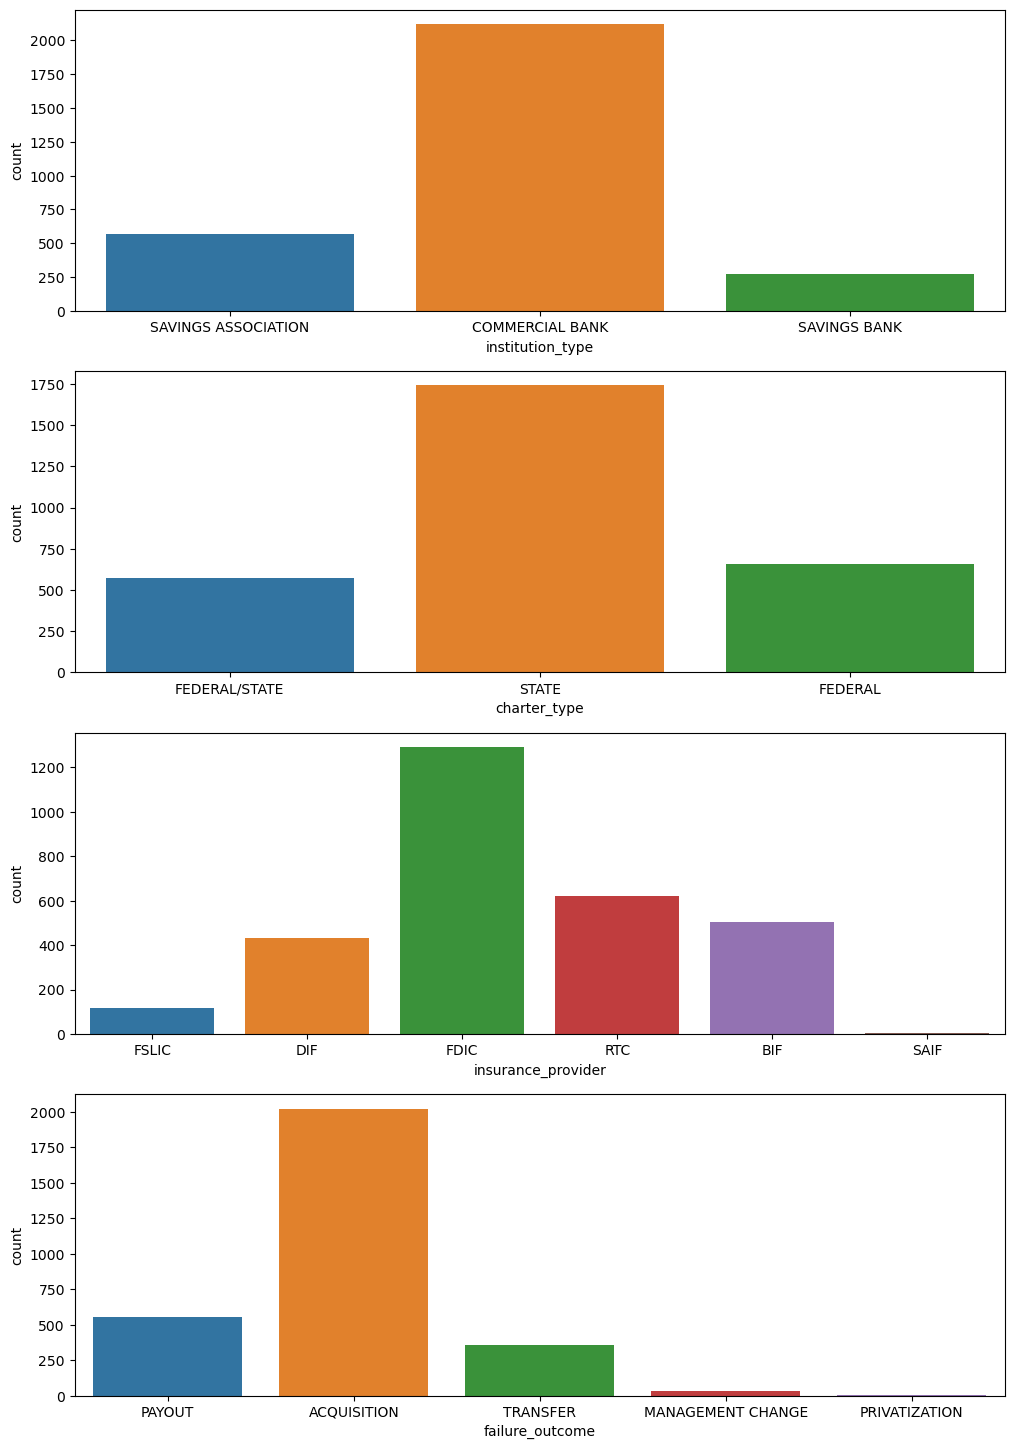

In [20]:
# Plotting total number of Instution type, Charter type, Insurance provider and Failure outcome
f, ax = plt.subplots(4, figsize=(12,18))
sns.countplot(x='institution_type', data=plot_df2, ax=ax[0])
sns.countplot(x='charter_type', data=plot_df2, ax=ax[1])
sns.countplot(x='insurance_provider', data=plot_df2, ax=ax[2])
sns.countplot(x='failure_outcome', data=plot_df2, ax=ax[3])

In [21]:
# Using our plot_df2 variable that we saved earlier: (Will be used for plotting and visualization)
plot_df2.head()

,Unnamed: 0,id,institution_name,institution_type,charter_type,headquarters,latitude,longitude,failure_date,insurance_provider,failure_outcome,total_deposits,total_assets,liquidity,estimated_loss,data_type,failure_year,failure_month,city,state
0,1,1,AMERICAN DIVERSIFIED SAVINGS BANK,SAVINGS ASSOCIATION,FEDERAL/STATE,"COSTA MESA, CA",33.663339,-117.903317,1986-02-14,FSLIC,PAYOUT,958.953,978.635,0.979888,472.36480,train,1986,2,COSTA MESA,CA
1,2,2,COMMUNITYSOUTH BANK AND TRUST,COMMERCIAL BANK,STATE,"EASLEY, SC",34.826928,-82.581705,2011-01-21,DIF,ACQUISITION,314.250,340.986,0.921592,51.33000,train,2011,1,EASLEY,SC
2,3,3,WATSON STATE BANK,COMMERCIAL BANK,STATE,"WATSON, MN",45.009723,-95.801348,1988-09-30,FDIC,ACQUISITION,12.865,13.731,0.936931,5.10400,train,1988,9,WATSON,MN
3,4,4,FIRST AMERICA FSB,SAVINGS BANK,STATE,"LONGMONT, CO",40.167212,-105.101929,1990-03-16,RTC,PAYOUT,146.818,187.366,0.783589,41.29300,train,1990,3,LONGMONT,CO
4,5,5,BANK OF HUNTER,COMMERCIAL BANK,STATE,"HUNTER, OK",36.563643,-97.661163,1985-04-04,FDIC,ACQUISITION,3.109,3.001,1.035988,1.19114,train,1985,4,HUNTER,OK


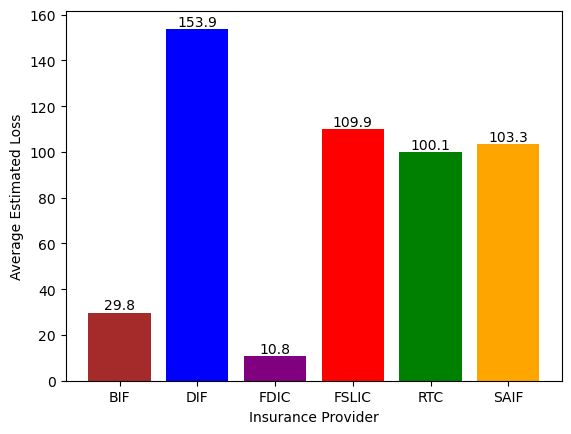

In [22]:
# Taking average estimated losses of each insurance provider and charting them
## This has been done to see which loans provided by which insurer are defaulting. 
## This might give an idea about collection efficiency of different insurance provider
grouped = plot_df2.groupby('insurance_provider')
average_losses = {}

for name, group in grouped:
    average_losses[name] = group['estimated_loss'].mean()

color_map = {'FSLIC': 'red', 'DIF': 'blue', 'RTC': 'green', 'FDIC': 'purple', 'BIF': 'brown', 'SAIF': 'orange'}
colors = [color_map[x] for x in average_losses.keys()]

plt.bar(average_losses.keys(), average_losses.values(), color=colors)
plt.xlabel('Insurance Provider')
plt.ylabel('Average Estimated Loss')

for provider, avg_loss in average_losses.items():
    plt.text(provider, avg_loss, '{:.1f}'.format(avg_loss), ha='center', va='bottom')

plt.show()

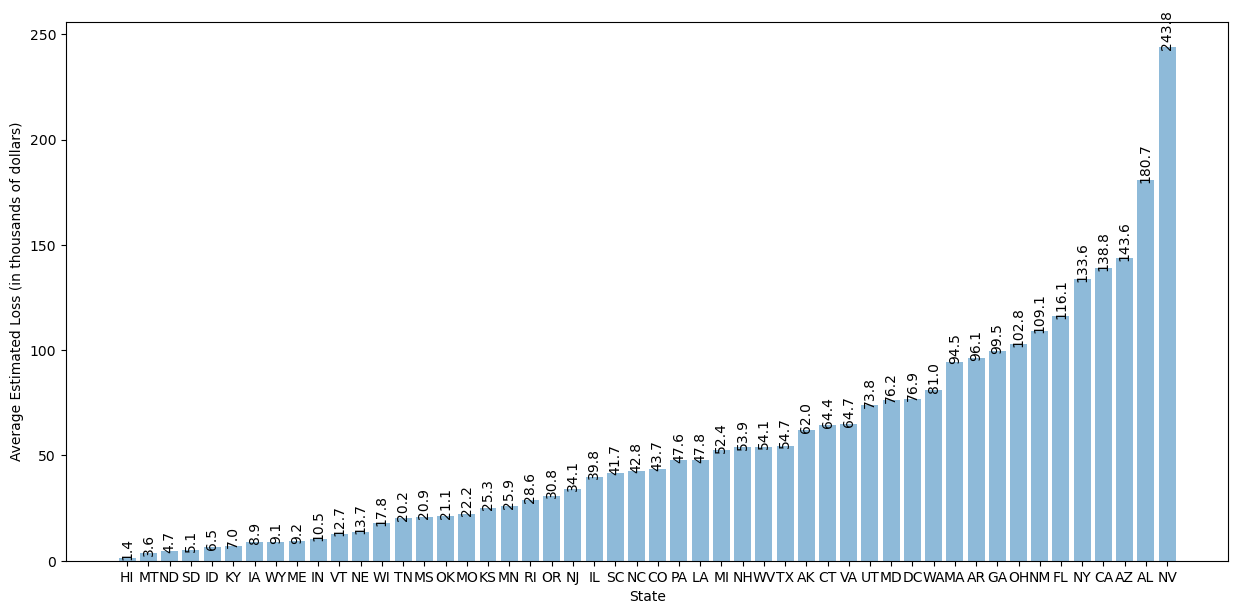

In [23]:
# Plotting average estimated losses state wise to get an idea of which states have average highest losses

grouped = plot_df2.groupby('state')
average_losses = {}

for name, group in grouped:
    average_losses[name] = group['estimated_loss'].mean()

average_losses = {k: v for k, v in sorted(average_losses.items(), key=lambda item: item[1])}

fig, ax = plt.subplots(figsize=(15, 7))
bar = ax.bar(average_losses.keys(), average_losses.values(), align='center', alpha=0.5)
ax.set_xlabel('State')
ax.set_ylabel('Average Estimated Loss (in thousands of dollars)')

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height-1,
            '%.1f' % height, ha='center', va='bottom', rotation=90)

plt.show()

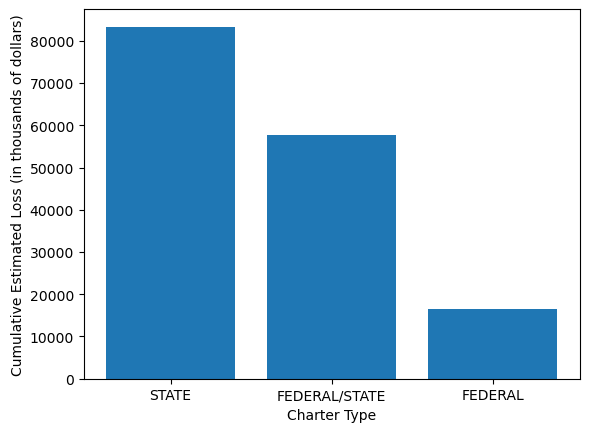

In [24]:
# Plotting estimated losses by charter type to get which category of insurance providers have higher losses
grouped = plot_df2.groupby('charter_type')
estimated_losses = {}

for name, group in grouped:
    estimated_losses[name] = group['estimated_loss'].sum()

estimated_losses = {k: v for k, v in sorted(estimated_losses.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots()
ax.bar(estimated_losses.keys(), estimated_losses.values())
ax.set_xlabel('Charter Type')
ax.set_ylabel('Cumulative Estimated Loss (in thousands of dollars)')

plt.show()

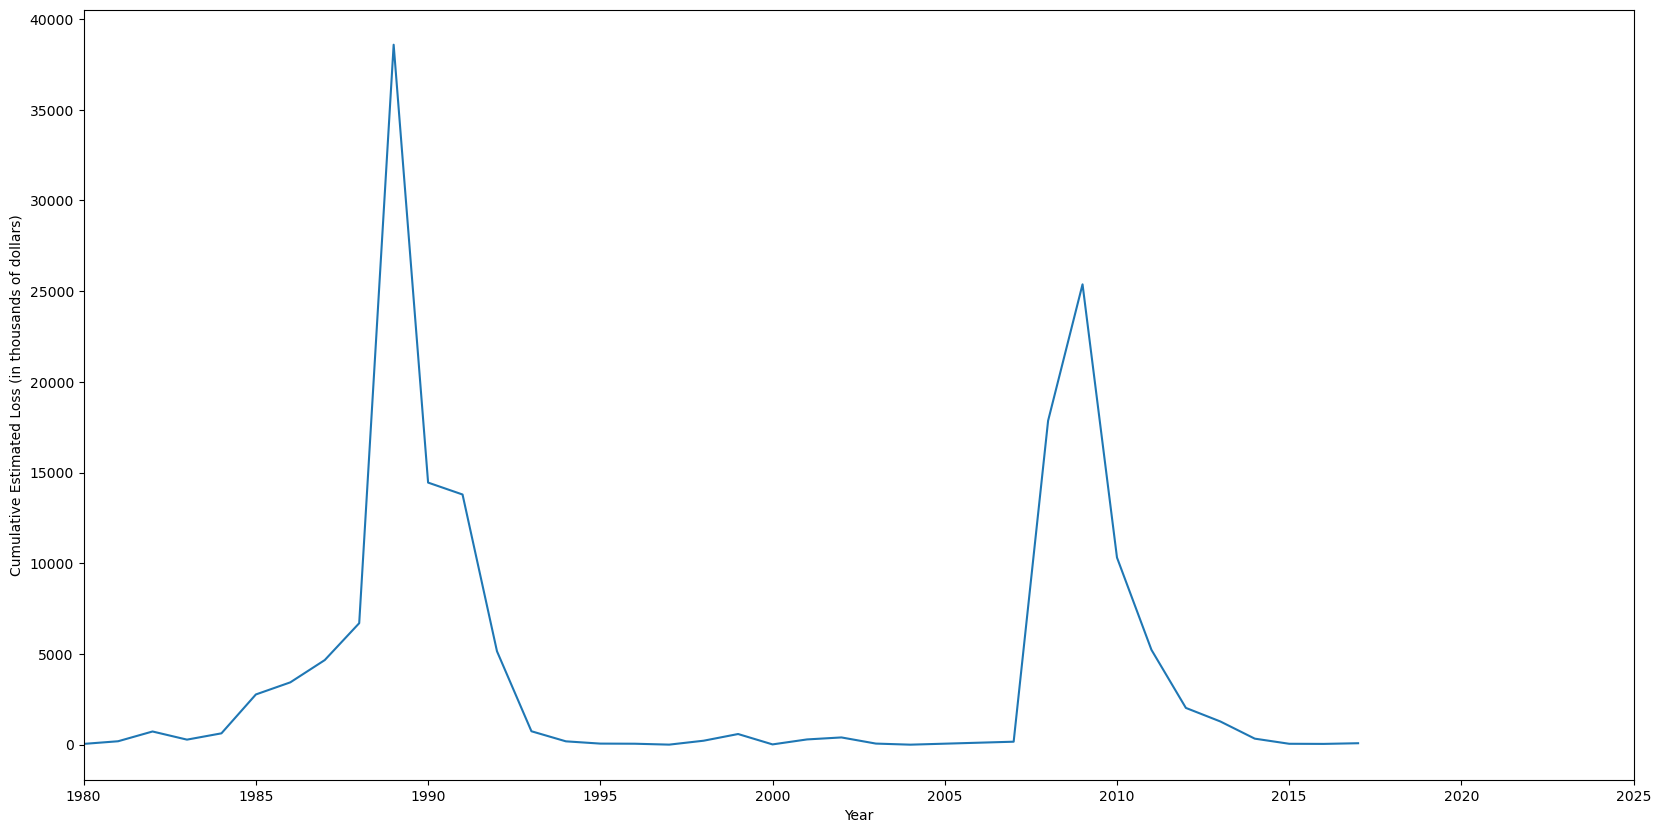

In [25]:
# Plotting estimated losses vs failure year to see largest losses occurred in which particular year

grouped = plot_df2.groupby('failure_year')
estimated_losses = {}

for name, group in grouped:
    estimated_losses[name] = group['estimated_loss'].sum()

estimated_losses = {k: v for k, v in sorted(estimated_losses.items(), key=lambda item: item[0])}

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(estimated_losses.keys(), estimated_losses.values())
ax.set_xlabel('Year')
ax.set_ylabel('Cumulative Estimated Loss (in thousands of dollars)')
ax.set_xlim(left=1980, right=2025)

plt.show()

# Graph Inference:
## From our graph above we see largest losses occurred in 1990 and 2008.
In 1990 and 2008, USA faced a recession because of housing prices.

(a) This indicates most loans prior to the crisis were mortgage loans. 

(b) This can be confirmed because we do not see estimated losses peak in 2000, where we had a tech bubble

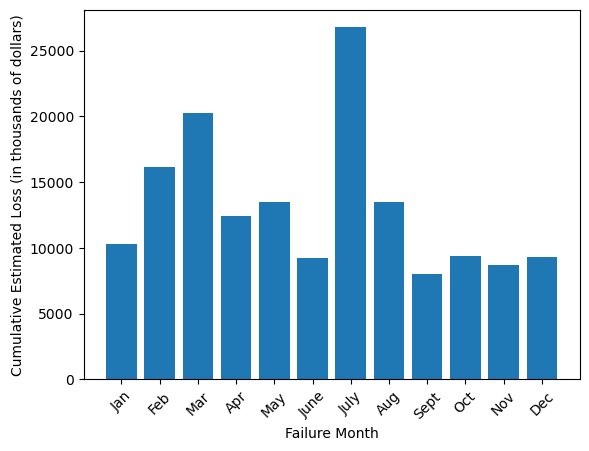

In [26]:
# Plotting estimated losses by Month to understand which months face highest losses

grouped = plot_df2.groupby('failure_month')
estimated_losses = {}

for name, group in grouped:
    estimated_losses[name] = group['estimated_loss'].sum()

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 
          'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots()
ax.bar(months, [estimated_losses[i+1] for i in range(12)])
ax.set_xlabel('Failure Month')
ax.set_ylabel('Cumulative Estimated Loss (in thousands of dollars)')
plt.xticks(rotation=45)
plt.show()


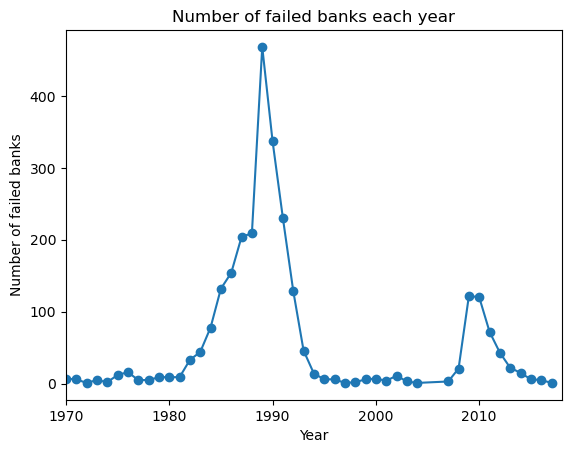

In [27]:
# Plot the count of failed banks each year

failures_by_year = plot_df2.groupby('failure_year').count()['institution_name']
plt.plot(failures_by_year.index, failures_by_year.values, '-o')
plt.xlabel('Year')
plt.ylabel('Number of failed banks')
plt.title('Number of failed banks each year')
plt.xlim(1970, 2018) # Add x-axis range
plt.show()

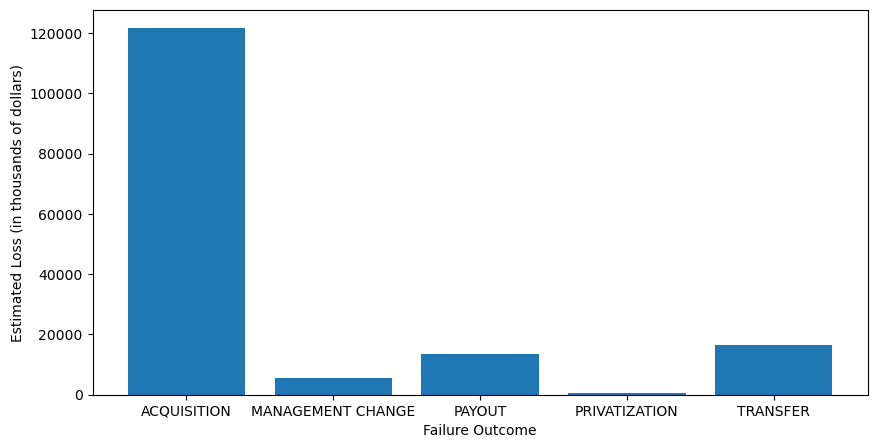

In [28]:
# Plot estimated losses vs failure outcome. This tells us that most of the insurance providers that failed were acquired.

grouped = plot_df2.groupby('failure_outcome')
estimated_losses = {}

for name, group in grouped:
    estimated_losses[name] = group['estimated_loss'].sum()

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(estimated_losses.keys(), estimated_losses.values())
ax.set_xlabel('Failure Outcome')
ax.set_ylabel('Estimated Loss (in thousands of dollars)')

plt.show()

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


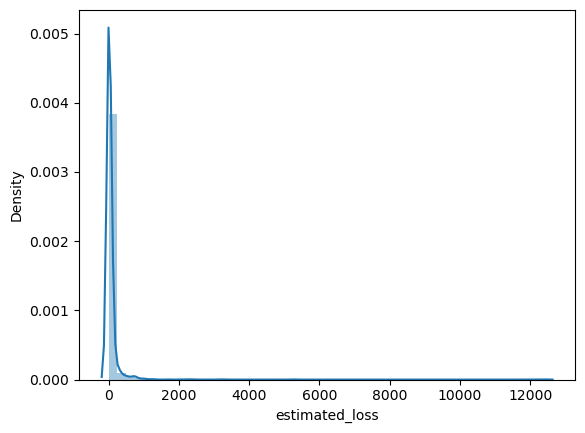

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


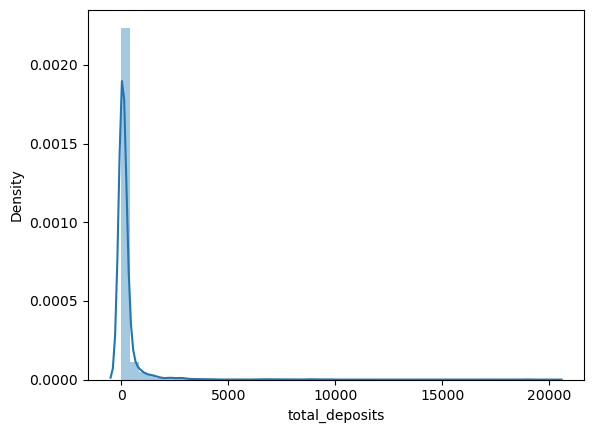

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


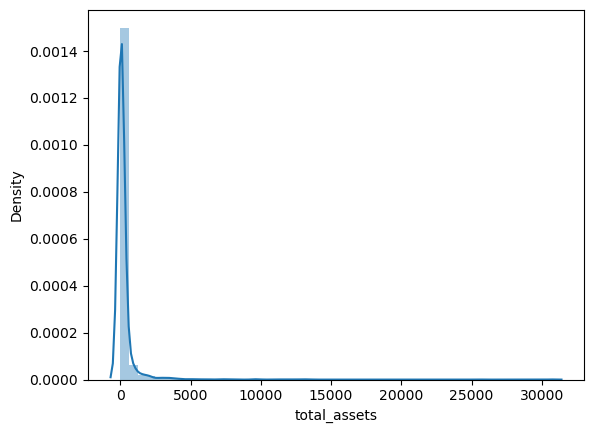

C:\Users\sauvi\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


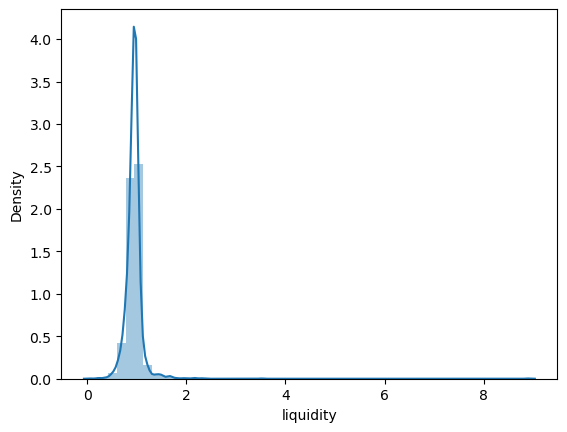

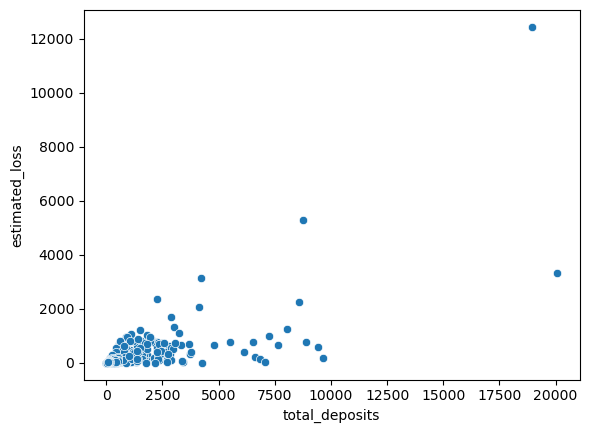

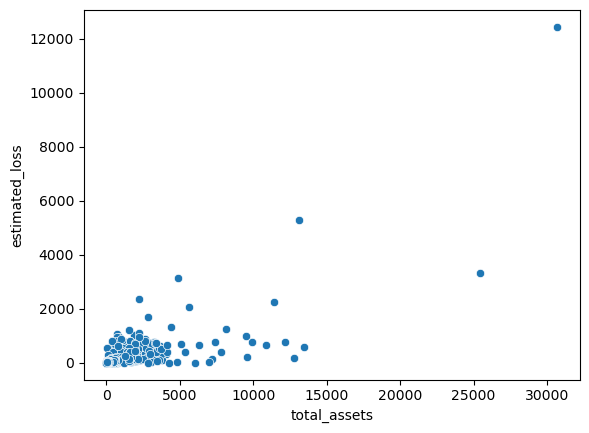

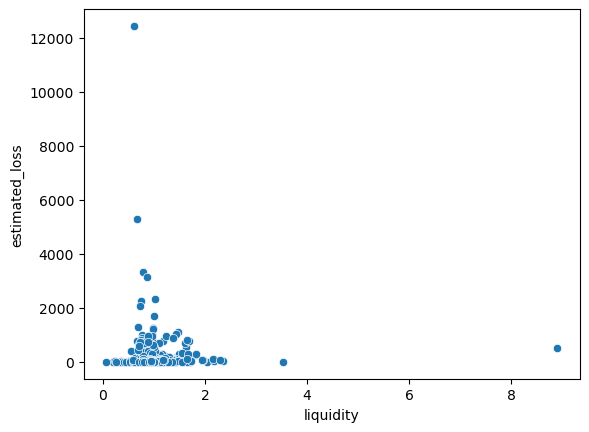

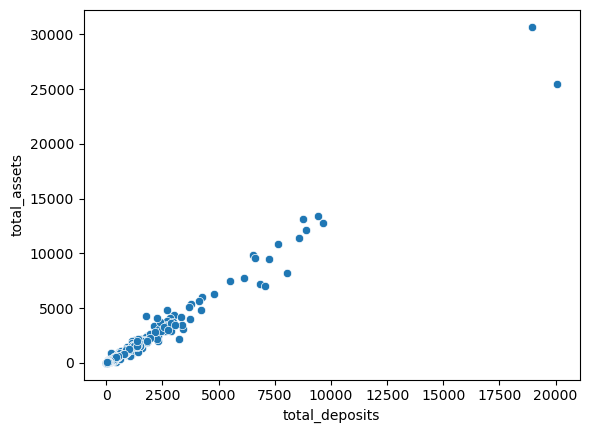

In [29]:
# Plot distribution of the target variable "estimated_loss"
sns.distplot(plot_df2["estimated_loss"])
plt.show()
# Plot distribution of the "total_deposits"
sns.distplot(plot_df2["total_deposits"])
plt.show()
# Plot distribution of the "total_assets"
sns.distplot(plot_df2["total_assets"])
plt.show()
# Plot distribution of the "liquidity"
sns.distplot(plot_df2["liquidity"])
plt.show()
# Plot a scatter plot of "estimated_loss" vs "total_deposits"
sns.scatterplot(x="total_deposits", y="estimated_loss", data=plot_df2)
plt.show()
# Plot a scatter plot of "estimated_loss" vs "total_assets"
sns.scatterplot(x="total_assets", y="estimated_loss", data=plot_df2)
plt.show()
# Plot a scatter plot of "estimated_loss" vs "liquidity"
sns.scatterplot(x="liquidity", y="estimated_loss", data=plot_df2)
plt.show()
# Plot a scatter plot of "total_deposits" vs "total_assets"
sns.scatterplot(x="total_deposits", y="total_assets", data=plot_df2)
plt.show()

# Modeling and Machine Learning

In [30]:
# Dropping the estimated loss columns from train_X data and adding it to train_y data
train_X = data_df.drop(["Unnamed: 0","id", "estimated_loss"], axis=1)
train_y = data_df["estimated_loss"]
train_X.head()

mask1 = (data_df["data_type"]=="train")
mask2 = (data_df["data_type"]=="test")


train_X = data_df[mask1].drop(["Unnamed: 0","id", "estimated_loss"], axis=1)
train_y = data_df[mask1]["estimated_loss"]

test_X = data_df[mask2].drop(["Unnamed: 0","id", "estimated_loss"], axis=1)
test_y = data_df[mask2]["estimated_loss"]

In [31]:
# Fetching data points for training the data
train_X = train_X[['total_deposits','total_assets', 
                   'liquidity', 'failure_year', 'failure_month','institution_type_COMMERCIAL BANK', 
                   'institution_type_SAVINGS ASSOCIATION', 'institution_type_SAVINGS BANK',
                   'charter_type_FEDERAL', 'charter_type_FEDERAL/STATE',
                   'charter_type_STATE', 'latitude_bins_0', 'latitude_bins_2',
                   'latitude_bins_4', 'latitude_bins_5', 'latitude_bins_6',
                   'latitude_bins_7', 'latitude_bins_8', 'longitude_bins_0',
                   'longitude_bins_1', 'longitude_bins_2', 'longitude_bins_4',
                   'longitude_bins_5', 'longitude_bins_6', 'longitude_bins_7',
                   'longitude_bins_8', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
                   'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_FL', 'state_GA',
                   'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
                   'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
                   'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
                   'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
                   'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
                   'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
                   'state_WA', 'state_WI', 'state_WV', 'state_WY',
                   'insurance_provider_BIF', 'insurance_provider_DIF',
                   'insurance_provider_FDIC', 'insurance_provider_FSLIC',
                   'insurance_provider_RTC', 'insurance_provider_SAIF',
                   'failure_outcome_ACQUISITION', 'failure_outcome_MANAGEMENT CHANGE',
                   'failure_outcome_PAYOUT', 'failure_outcome_PRIVATIZATION',
                   'failure_outcome_TRANSFER','longitude_scaled','latitude_scaled']]

In [32]:
# Checking which features are of importance and infering whether to include in our feature list or not
from matplotlib import pyplot as plt
train_X1, val_X1, train_y1, val_y1 = train_test_split(train_X, train_y,test_size=0.3, random_state=0)
clf = RandomForestRegressor()
clf.fit(train_X1, train_y1)
predictions_val = clf.predict(val_X1)
mape = np.mean(np.abs((val_y1 - predictions_val) / val_y1))
sorted(zip(clf.feature_importances_,train_X.columns, ), reverse=True)[:20]

[(0.45488801702016374, 'total_deposits'),
 (0.3644624021486475, 'total_assets'),
 (0.04872187491517377, 'latitude_scaled'),
 (0.028325214836690534, 'failure_year'),
 (0.028221688951521794, 'liquidity'),
 (0.01393267322012833, 'failure_month'),
 (0.009244860915235785, 'longitude_scaled'),
 (0.008069155428641867, 'latitude_bins_7'),
 (0.005630544903936144, 'state_FL'),
 (0.004500753319868788, 'state_CA'),
 (0.0027679428995331956, 'latitude_bins_5'),
 (0.002755595590946519, 'failure_outcome_ACQUISITION'),
 (0.0024580820287064572, 'state_TX'),
 (0.0021131682887487475, 'institution_type_SAVINGS BANK'),
 (0.0020543212624019006, 'state_AZ'),
 (0.001987362721090116, 'state_NV'),
 (0.0017196713845889539, 'institution_type_COMMERCIAL BANK'),
 (0.001712809799995409, 'state_OH'),
 (0.001690087065419085, 'state_GA'),
 (0.001607523703100384, 'failure_outcome_PAYOUT')]

In [33]:
# Creating different sets and adding various parameters to test which features provide the best estimate
train_set_1 = train_X[['total_deposits','total_assets', 
                   'liquidity', 'failure_year', 'failure_month','institution_type_COMMERCIAL BANK', 
                   'institution_type_SAVINGS ASSOCIATION', 'institution_type_SAVINGS BANK',
                   'charter_type_FEDERAL', 'charter_type_FEDERAL/STATE',
                   'charter_type_STATE', 'latitude_bins_0', 'latitude_bins_2',
                   'latitude_bins_4', 'latitude_bins_5', 'latitude_bins_6',
                   'latitude_bins_7', 'latitude_bins_8', 'longitude_bins_0',
                   'longitude_bins_1', 'longitude_bins_2', 'longitude_bins_4',
                   'longitude_bins_5', 'longitude_bins_6', 'longitude_bins_7',
                   'longitude_bins_8', 'state_AK', 'state_AL', 'state_AR', 'state_AZ',
                   'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_FL', 'state_GA',
                   'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
                   'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
                   'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
                   'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
                   'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
                   'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
                   'state_WA', 'state_WI', 'state_WV', 'state_WY',
                   'insurance_provider_BIF', 'insurance_provider_DIF',
                   'insurance_provider_FDIC', 'insurance_provider_FSLIC',
                   'insurance_provider_RTC', 'insurance_provider_SAIF',
                   'failure_outcome_ACQUISITION', 'failure_outcome_MANAGEMENT CHANGE',
                   'failure_outcome_PAYOUT', 'failure_outcome_PRIVATIZATION',
                   'failure_outcome_TRANSFER']]

train_set_2 = train_X[['total_deposits','total_assets', 
                   'liquidity', 'failure_year', 'failure_month','institution_type_COMMERCIAL BANK', 
                   'institution_type_SAVINGS ASSOCIATION', 'institution_type_SAVINGS BANK',
                   'charter_type_FEDERAL', 'charter_type_FEDERAL/STATE',
                   'charter_type_STATE', 'latitude_bins_0', 'latitude_bins_2',
                   'latitude_bins_4', 'latitude_bins_5', 'latitude_bins_6',
                   'latitude_bins_7', 'latitude_bins_8', 'longitude_bins_0',
                   'longitude_bins_1', 'longitude_bins_2', 'longitude_bins_4',
                   'longitude_bins_5', 'longitude_bins_6', 'longitude_bins_7',
                   'longitude_bins_8', 'insurance_provider_BIF', 'insurance_provider_DIF',
                   'insurance_provider_FDIC', 'insurance_provider_FSLIC',
                   'insurance_provider_RTC', 'insurance_provider_SAIF',
                   'failure_outcome_ACQUISITION', 'failure_outcome_MANAGEMENT CHANGE',
                   'failure_outcome_PAYOUT', 'failure_outcome_PRIVATIZATION',
                   'failure_outcome_TRANSFER']]

train_set_3 = train_X[['total_deposits','total_assets']]

train_set_4 = train_X[['total_deposits','total_assets', 
                   'liquidity', 'failure_year', 'failure_month','institution_type_COMMERCIAL BANK', 
                   'institution_type_SAVINGS ASSOCIATION', 'institution_type_SAVINGS BANK',
                   'state_AK', 'state_AL', 'state_AR', 'state_AZ',
                   'state_CA', 'state_CO', 'state_CT', 'state_DC', 'state_FL', 'state_GA',
                   'state_HI', 'state_IA', 'state_ID', 'state_IL', 'state_IN', 'state_KS',
                   'state_KY', 'state_LA', 'state_MA', 'state_MD', 'state_ME', 'state_MI',
                   'state_MN', 'state_MO', 'state_MS', 'state_MT', 'state_NC', 'state_ND',
                   'state_NE', 'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
                   'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI', 'state_SC',
                   'state_SD', 'state_TN', 'state_TX', 'state_UT', 'state_VA', 'state_VT',
                   'state_WA', 'state_WI', 'state_WV', 'state_WY']]

train_set_5 = train_X[['total_deposits','total_assets','failure_year', 'failure_month',
                   'charter_type_FEDERAL', 'charter_type_FEDERAL/STATE',
                   'charter_type_STATE', 'latitude_bins_0', 'latitude_bins_2',
                   'latitude_bins_4', 'latitude_bins_5', 'latitude_bins_6',
                   'latitude_bins_7', 'latitude_bins_8', 'longitude_bins_0',
                   'longitude_bins_1', 'longitude_bins_2', 'longitude_bins_4',
                   'longitude_bins_5', 'longitude_bins_6', 'longitude_bins_7',
                   'longitude_bins_8',
                   'insurance_provider_BIF', 'insurance_provider_DIF',
                   'insurance_provider_FDIC', 'insurance_provider_FSLIC',
                   'insurance_provider_RTC', 'insurance_provider_SAIF',
                   'failure_outcome_ACQUISITION', 'failure_outcome_MANAGEMENT CHANGE',
                   'failure_outcome_PAYOUT', 'failure_outcome_PRIVATIZATION',
                   'failure_outcome_TRANSFER']]

train_set_6 = train_X[['total_deposits','total_assets', 
                   'failure_year','failure_month']]

train_set_7 = train_X[['total_deposits','total_assets', 'failure_year', 'failure_month','institution_type_COMMERCIAL BANK', 
                   'institution_type_SAVINGS ASSOCIATION', 'institution_type_SAVINGS BANK',
                   'charter_type_FEDERAL', 'charter_type_FEDERAL/STATE',
                   'charter_type_STATE',
                   'insurance_provider_BIF', 'insurance_provider_DIF',
                   'insurance_provider_FDIC', 'insurance_provider_FSLIC',
                   'insurance_provider_RTC', 'insurance_provider_SAIF',
                   'failure_outcome_ACQUISITION', 'failure_outcome_MANAGEMENT CHANGE',
                   'failure_outcome_PAYOUT', 'failure_outcome_PRIVATIZATION',
                   'failure_outcome_TRANSFER','longitude_scaled','latitude_scaled']]

train_set_8 = train_X[['total_deposits', 'total_assets', 'failure_year', 'charter_type_FEDERAL', 'charter_type_FEDERAL/STATE',
                   'charter_type_STATE','longitude_scaled','latitude_scaled']]


train_sets = [train_set_1, train_set_2, train_set_3, train_set_4, train_set_5, train_set_6, train_set_7, train_set_8]

In [34]:
# Doing cross-validation to see which regression model to consider for prediction of estimated loss
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.tree import DecisionTreeRegressor
n_splits = 5 # Number of splits to check values at different iterations
kf = KFold(n_splits=n_splits, shuffle=True)

# Different model
models = [TheilSenRegressor(), GaussianProcessRegressor(), HuberRegressor(), LinearRegression(), RandomForestRegressor(),
          SVR(), MLPRegressor(),GradientBoostingRegressor(),DecisionTreeRegressor(), 
          AdaBoostRegressor(), ARDRegression(), KNeighborsRegressor()]

results = pd.DataFrame(columns=['Model', 'Mean_Neg_Percent_Error', 'Standard_Deviation'])

# Running a loop over all models
for model in models:
    scoring=('neg_mean_absolute_percentage_error','neg_mean_absolute_percentage_error')
    cv_results = cross_validate(model, train_X, train_y, cv=kf, scoring='neg_mean_absolute_percentage_error', return_train_score=False)
    mean = cv_results['test_score'].mean()
    std = cv_results['test_score'].std()
    results = results.append({'Model': model, 'Mean_Neg_Percent_Error': mean, 'Standard_Deviation': std}, ignore_index=True)

print(results) # Adding results in tabular form

C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\1290843490.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model, 'Mean_Neg_Percent_Error': mean, 'Standard_Deviation': std}, ignore_index=True)
C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\1290843490.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model, 'Mean_Neg_Percent_Error': mean, 'Standard_Deviation': std}, ignore_index=True)
C:\Users\sauvi\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimiz

                                         Model  Mean_Neg_Percent_Error  \
0   TheilSenRegressor(max_subpopulation=10000)             -137.131246   
1                   GaussianProcessRegressor()               -0.929788   
2                             HuberRegressor()             -114.276274   
3                           LinearRegression()             -306.687916   
4                      RandomForestRegressor()             -144.987252   
5                                        SVR()              -37.087371   
6                               MLPRegressor()             -186.395683   
7                  GradientBoostingRegressor()             -117.296394   
8                      DecisionTreeRegressor()              -84.391284   
9                          AdaBoostRegressor()             -331.069560   
10                             ARDRegression()             -275.803892   
11                       KNeighborsRegressor()             -183.659726   

    Standard_Deviation  
0           

C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\1290843490.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model, 'Mean_Neg_Percent_Error': mean, 'Standard_Deviation': std}, ignore_index=True)
C:\Users\sauvi\AppData\Local\Temp\ipykernel_40240\1290843490.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model, 'Mean_Neg_Percent_Error': mean, 'Standard_Deviation': std}, ignore_index=True)


In [35]:
# Splitting the training data into train and test to evaluate the performance of Gaussian model selected based on above results:
for i in range(len(train_sets)):
    train_X1, val_X1, train_y1, val_y1 = train_test_split(train_sets[i], train_y,test_size=0.3, random_state=0)
    models = [GaussianProcessRegressor(alpha=0.1)] # We have added hyperparameter alpha to avoid over- and under-fitting of our model
    print("test_set:", i)
    
    # Running a loop to evaluate which features provide the lowest mape for our test and train set on our selected model
    for model in models:
        model.fit(train_X1, train_y1)
        pred_train_y = model.predict(train_X1)
        pred_y = model.predict(val_X1)
        mae = mean_absolute_error(val_y1, pred_y)
        mape = mean_absolute_percentage_error(val_y1, pred_y)
        print(f"{model}: MAE={mae}, MAPE={mape}")
        # Feature selection
        mae = mean_absolute_error(train_y1, pred_train_y)
        mape = mean_absolute_percentage_error(train_y1, pred_train_y)
        print("train_set:",i)
        print(f"{model}: MAE={mae}, MAPE={mape}")
        
# We see that we get lowest MAPE in test and train data for train_set_6 (test/train 5 here). This ensures there is no overfitting

test_set: 0
GaussianProcessRegressor(alpha=0.1): MAE=56.29494274042167, MAPE=0.9129195791655774
train_set: 0
GaussianProcessRegressor(alpha=0.1): MAE=5.611581503173737, MAPE=0.08476011703037781
test_set: 1
GaussianProcessRegressor(alpha=0.1): MAE=56.2074630995723, MAPE=0.8897190243247552
train_set: 1
GaussianProcessRegressor(alpha=0.1): MAE=5.606108960825422, MAPE=0.08864095904758297
test_set: 2
GaussianProcessRegressor(alpha=0.1): MAE=54.19783475219198, MAPE=5.933511388419833
train_set: 2
GaussianProcessRegressor(alpha=0.1): MAE=6.145478193376985, MAPE=4.85945220564871
test_set: 3
GaussianProcessRegressor(alpha=0.1): MAE=56.06580483051735, MAPE=0.8671096346643377
train_set: 3
GaussianProcessRegressor(alpha=0.1): MAE=5.5933391599642395, MAPE=0.13787540680712806
test_set: 4
GaussianProcessRegressor(alpha=0.1): MAE=56.19431321773742, MAPE=0.8865358055411614
train_set: 4
GaussianProcessRegressor(alpha=0.1): MAE=5.605382646861171, MAPE=0.09312302324853637
test_set: 5
GaussianProcessRegress

# Forecasting

In [36]:
# Drop estimated loss column from the test set since we will run our model to predict estimated losses
test_X = test_data.drop(["Unnamed: 0","id", "estimated_loss"], axis=1)
test_X.head()

,institution_name,headquarters,latitude,longitude,failure_date,total_deposits,total_assets,liquidity,data_type,failure_year,failure_month,city,longitude_scaled,latitude_scaled,institution_type_COMMERCIAL BANK,institution_type_SAVINGS ASSOCIATION,institution_type_SAVINGS BANK,charter_type_FEDERAL,charter_type_FEDERAL/STATE,charter_type_STATE,latitude_bins_0,latitude_bins_2,latitude_bins_4,latitude_bins_5,latitude_bins_6,latitude_bins_7,latitude_bins_8,longitude_bins_0,longitude_bins_1,longitude_bins_2,longitude_bins_4,longitude_bins_5,longitude_bins_6,longitude_bins_7,longitude_bins_8,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,insurance_provider_BIF,insurance_provider_DIF,insurance_provider_FDIC,insurance_provider_FSLIC,insurance_provider_RTC,insurance_provider_SAIF,failure_outcome_ACQUISITION,failure_outcome_MANAGEMENT CHANGE,failure_outcome_PAYOUT,failure_outcome_PRIVATIZATION,failure_outcome_TRANSFER
0,HOHENWALD NATIONAL BANK,"HOHENWALD, TN",35.547851,-87.551963,1982-09-03,24.334,27.053,0.899494,test,1982,9,HOHENWALD,-0.539022,0.340681,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,ROSEMOUNT NATIONAL BANK,"ROSEMOUNT, MN",44.739187,-93.126110,2011-04-15,20.980,21.454,0.977906,test,2011,4,ROSEMOUNT,-0.575572,0.517864,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,CITIZENS BANK OF GLENDALE,"DENVER, CO",39.739236,-104.984862,1987-08-27,4.036,4.384,0.920620,test,1987,8,DENVER,-0.653329,0.421479,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3,THE STERLINGTON BANK,"STERLINGTON, LA",32.694432,-92.076030,1989-07-13,14.646,15.243,0.960834,test,1989,7,STERLINGTON,-0.568686,0.285676,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,PEOPLES S & L ASSOC.,"HAMPTON, VA",37.052031,-76.285636,1989-06-29,24.322,23.943,1.015829,test,1989,6,HAMPTON,-0.465150,0.369678,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [37]:
# Training the data using relevant datapoints collected from checking which features would give the best estimates
test_X = test_X[['total_deposits','total_assets', 
                   'failure_year','failure_month']]

# Here we have taken features of test_set_6

In [38]:
# Checking our columns of our feature list
train_set_6.head()

,total_deposits,total_assets,failure_year,failure_month
0,958.953,978.635,1986,2
1,314.250,340.986,2011,1
2,12.865,13.731,1988,9
3,146.818,187.366,1990,3
4,3.109,3.001,1985,4


In [39]:
# assigning a variable to test_X (Which contains our selected features)
remove = test_X

In [40]:
# As Gaussian had the least MAPE value, we chose gaussian to predict expected losses on test data
model = GaussianProcessRegressor(alpha=0.1)
model.fit(train_set_6, train_y)
test_X["estimated_loss"] = model.predict(remove)

In [41]:
# Assigning "id" column to our predicted data set
test_X["id"] = test_data["id"]

In [42]:
# Adding the results to "Prediction file"
prediction_df = test_X[["id","estimated_loss"]]
prediction_df.to_csv('prediction.csv',index=False)

In [43]:
# Checking if we have got our estimated loss
prediction_df.set_index('id')

,estimated_loss
id,
1,0.198882
2,0.570559
3,0.894743
4,3.135478
5,4.331268
...,...
352,0.111655
353,1.497339
354,2.716983
